In [2]:
using DifferentialEquations
using Plots, Colors, LaTeXStrings

In [3]:
using Plots.Measures
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

Plots.PyPlotBackend()

In [4]:
include("RetinalChaos.jl")

┌ Warning: Symbolic calculations could not initiate. Likely there's a function which is not differentiable by SymEngine.
└ @ ParameterizedFunctions C:\Users\mtarc\.julia\packages\ParameterizedFunctions\WcTrd\src\ode_def_opts.jl:244


extract_points

# RetinalChaos.jl: An introduction
### In order to understand the code published here, these notebooks will act as simple tutorials on both how the model was designed. 

## Table of contents:

### _**[1] Introduction, Motivation, and Components**_
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### **[1.3] Acetylcholine Diffusion and Dynamics**
#### [1.4] Gaussian White noise and dynamics

### [2] Analyzing Data Output of the model
#### [2.1] Dynamical Analysis
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers

# Just to recap the model in full is 
\begin{align}
   C_m\frac{dV}{dt} &= I_{leak} + I_{Ca} + I_K + I_{app} + I_{noise}\\
   \tau_N\frac{dN}{dt} &= \Lambda(V)(N_\infty(V) - N)\\
   \tau_C\frac{d[Ca^{2+}]}{dt} &= C_0 + \delta I_{Ca}(V) -\lambda  [Ca^{2+}]\\
   \tau_a\frac{da}{dt} &= \alpha * [Ca^{2+}]^4 * \left(1- a\right) - a\\
   \tau_b\frac{db}{dt} &= \beta * a^4 * (1 - b) - b\\
   \tau_{[ACh]}\frac{d[ACh]}{dt} &=  \nabla_{xx}^2 [ACh] + \rho \Phi(V) -[ACh]
\end{align}

#### Each individual Variable functions at a specific time scale. This is what gives different parts of the model their oscillatory behavior. The timescales are demonstrated below in this figure. 

<img src="attachment:Fig1_Timescale_Diagram.png" width="750"/>

### [1.3] Acetylcholine Release, Diffusion, and Activation
- 

In [121]:
p_dict = read_JSON("params.json", is_type = Dict{Symbol, Float64});
u_dict = read_JSON("conds.json", is_type = Dict{Symbol, Float64});
p_dict[:I_app] = 2.0
p_dict[:D] = 0.01

0.01

In [122]:
println(p_dict[:ρ])
println(p_dict[:k_d])
println(p_dict[:τACh])

6.0
0.05
540.0


In [123]:
p0 = map(x -> Float64(p_dict[x]), BurstModel.params);
u0 = map(x -> Float64(u_dict[x]), BurstModel.syms);
tspan = (0.0, 60e3);
prob = ODEProblem(BurstModel, u0, tspan, p0);
println("Time it took to simulate 200ms:")
@time sol = solve(prob, saveat = 1.0);

Time it took to simulate 200ms:
  0.037573 seconds (128.12 k allocations: 14.683 MiB)


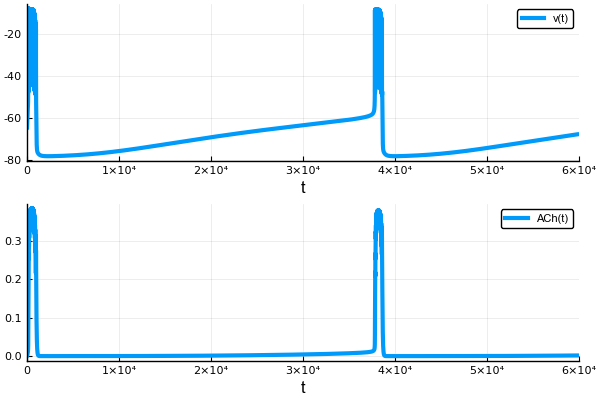

In [124]:
plot(sol, vars = [:v, :ACh], layout = grid(2, 1))

In [125]:
v_rng = LinRange(-90.0, 10.0, 100);
AChi = 0.0
ρ = p_dict[:ρ]
k = p_dict[:k]
println(k)
V0 = p_dict[:V0]
τACh = p_dict[:τACh]
fach(v) = (ρ * Φ(v, k, V0)) - (AChi)/τACh
ACh_rng = map(fach, v_rng);

0.2


In [126]:
xlims = (37e3, 40e3) 
xticks = (collect(xlims[1]:500:xlims[2]), collect(0:0.5:round(Int, tspan[end]/1000)))

fig2_Aa = plot(sol, 
    vars = [:v, :ACh], 
    ylabel = ["$(vt) (mV)" "[ACh] (mM)"], 
    xlabel = ["" "time (s)"], 
    c = [v_color ach_color], lw = 2.0,
    legend = :none, 
    layout = grid(2, 1), 
    xlims = xlims, 
    xticks = xticks
)
frame_stops = [1.0e3, 1.5e3, 2.0e3]
frame_stops .+= xlims[1]
ach_stops = map(t->sol(t)[6], frame_stops)
plot!(fig2_Aa[2], frame_stops, ach_stops, label = "Frame stops",
    seriestype = :scatter, marker = :star, markersize = 10.0)

fig2_Ab = plot(v_rng, ACh_rng, 
    c = ach_color, linestyle = :dot, lw = 4.0, 
    title = "Acetylcholine Release", titlefontsize = 12.0,
    xlabel = "$(vt) (mV)",ylabel = "$(delta)[ACh] (mM/s)", label = "")

fig2_A = plot(fig2_Aa, fig2_Ab, 
    layout = grid(1, 2, widths = [0.75, 0.25]), size = (700, 350))
title!(fig2_A[1], "A");

In [127]:
nx, ny = (50, 50)
c1x, c1y = (round(Int, nx/2), round(Int, ny/4))
c2x, c2y = (round(Int, nx/2), round(Int, ny/4*3))
D = p_dict[:D]
lattice = zeros(nx, ny)
lattice[c1x, c1y] = 0.6
bp_model = BurstPDE(nx, ny)

(::BurstPDE{Float64}) (generic function with 1 method)

In [128]:
time_range = collect(0:(xlims[end]-xlims[1]))
println(length(time_range))
lattice_c = zeros(nx, ny, length(time_range))
for (idx, t) in enumerate(time_range)
    #Each step, the cell releases 0.005 ACh
    if idx == 1
        lattice_c[c1x, c1y, idx] = sol(t+xlims[1])[6]
    else
        lattice_c[:, :, idx] = diffuse(lattice_c[:,:,idx-1], D, bp_model)
        lattice_c[c1x, c1y, idx] = sol(t+xlims[1])[6]
    end
end

3001


In [129]:
fig2_B = plot(xlims = (0, nx), ylims = (0, ny), layout = grid(1, length(frame_stops)), size = (1000, 250), 
    margin = 1mm
)
upper_lim = 0.08
for (idx, frame) in enumerate(frame_stops)
    frame_idx = Int(frame-xlims[1])
    #p = plot(xlims = (0.1, nx), ylims = (0.1, ny), 
    #    xaxis = false, yaxis = false)
    if idx == length(frame_stops)
        heatmap!(fig2_B[idx], lattice_c[:,:,frame_idx], c = :thermal, clims = (0.0, upper_lim), 
            aspect_ratio = :equal, grid = false,
            xaxis = false, yaxis = false
        )
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :cyan)), label = "")
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :circle, c = :cyan, markersize = 10.0, label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :red)), label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :circle, c = :red, markersize = 10.0, label = "")
        annotate!(fig2_B[idx], [40], [3], "t = $(time_range[frame_idx+1]/1000)s", :white)
    else
        heatmap!(fig2_B[idx], lattice_c[:,:,frame_idx], c = :thermal, clims = (0.0, upper_lim), 
            aspect_ratio = :equal, grid = false, colorbar = false, 
            xaxis = false, yaxis = false
        )
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :cyan)), label = "")
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :circle, c = :cyan, markersize = 10.0, label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :red)), label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :circle, c = :red, markersize = 10.0, label = "")
        annotate!(fig2_B[idx], [40], [3], "t=$(time_range[frame_idx+1]/1000)s", :white)
    end
end
fig2_B;

In [130]:
ach_rng = LinRange(0.0, 0.5, 100)
k_d = p_dict[:k_d]
println(k_d)
g_ACh = p_dict[:g_ACh]
println(g_ACh)
E_ACh = p_dict[:E_ACh]
println(E_ACh)
i_rng = map(a -> -g_ACh*ħ(a, k_d)*(-70.0-E_ACh), ach_rng);

ach_external = lattice_c[c1x, c1y+1, :];
i_synaptic = map(a -> -g_ACh*ħ(a, k_d)*(-70.0-E_ACh), ach_external);

0.05
1.0
0.0


In [131]:
fig2_Ca = plot(layout = (2,1))
plot!(fig2_Ca[1], sol, vars = [:ACh], c = :blue, label = "Cell 1 release",
    xlims = xlims, 
    xticks = xticks, 
    ylabel = "[ACh] (mM)",
    xlabel = ""
)
plot!(fig2_Ca[1], time_range.+xlims[1], ach_external, label = "Cell 2 Extracellular", 
    c = :red, lw = 3.0, legend = :topleft)

ach_rel = map(t->sol(t)[6], frame_stops)
ach_ext = map(t->lattice_c[c1x, c1y+1, Int(t-xlims[1])], frame_stops)
plot!(fig2_Ca[1], frame_stops, ach_rel, label = "",
    seriestype = :scatter, marker = :star, markersize = 10.0)
plot!(fig2_Ca[1], frame_stops, ach_ext, label = "",
    seriestype = :scatter, marker = :star, markersize = 10.0)

plot!(fig2_Ca[2], time_range./1000.0, i_synaptic, label = "", 
    c = :purple, lw = 2.0,
    ylabel = "$(i_ach) (pA)", xlabel = "time (s)"
)


fig2_Cb = plot(ach_rng, i_rng, label = "",
    xlabel = "Extracellular [ACh] (mM)", ylabel = "$(i_ach) (pA)", 
    title = "Induced $(i_ach)", titlefontsize = 12.0, 
    c = :green, lw = 3.0, 
)
fig2_C = plot(fig2_Ca, fig2_Cb, layout = grid(1,2, widths = [0.75, 0.25]))
title!(fig2_C[1], "C");

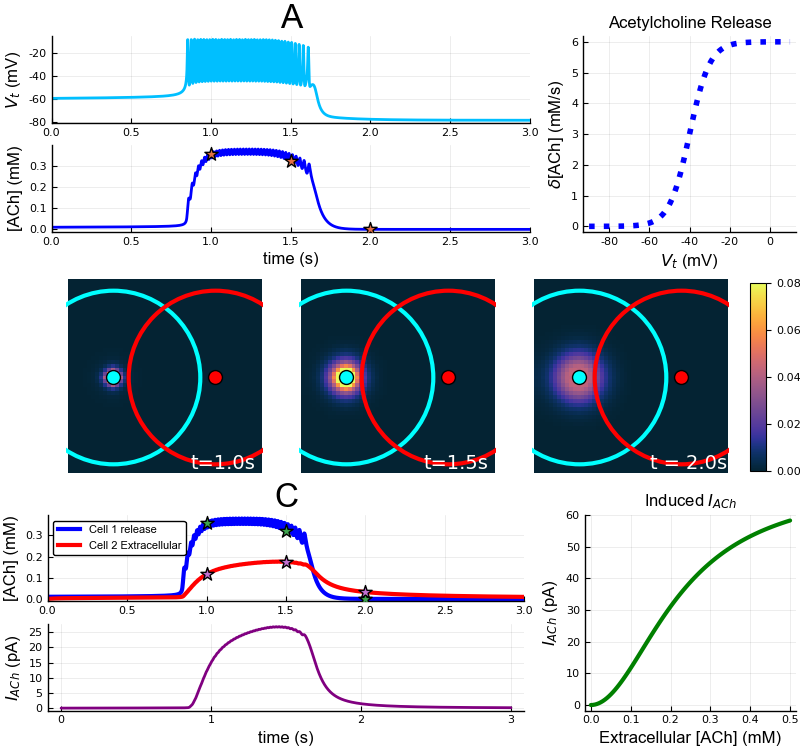

In [132]:
fig2 = plot(fig2_A, fig2_B, fig2_C, layout = grid(3, 1), size = (800, 750))

In [84]:
savefig(fig2, "$(figure_path)/Figure2_Acetylcholine_Rel_Diff_Activate.png")

### Supplemental Gif 1

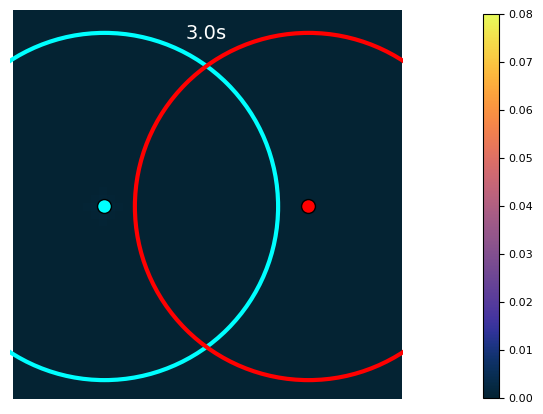

┌ Info: Saved animation to 
│   fn = C:\users\mtarc\JuliaScripts\RetinalChaos\Notebooks\Figures\Supplemental_Video1.gif
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\users\\mtarc\\JuliaScripts\\RetinalChaos\\Notebooks\\Figures\\Supplemental_Video1.gif")
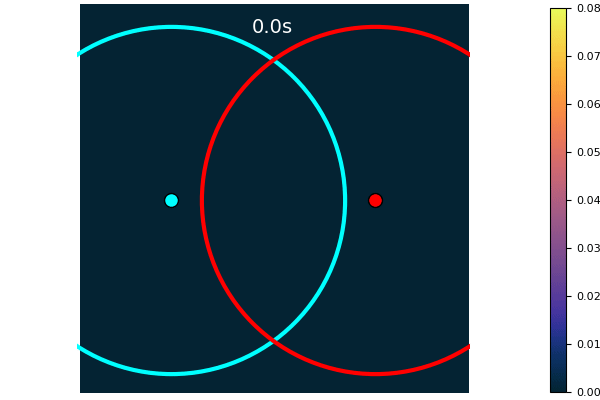

In [120]:
anim = @animate for i = 1:100:size(lattice_c, 3)
    p = plot(xlims = (0.1, nx), ylims = (0.1, ny), 
        xaxis = false, yaxis = false)
    heatmap!(p, lattice_c[:,:,i], c = :thermal, clims = (0.0, upper_lim), aspect_ratio = :equal, grid = false)
    scatter!(p, [c1y], [c1x], marker = :hexagon, m = (250.0, :transparent, stroke(3.0, :cyan)), label = "")
    scatter!(p, [c1y], [c1x], marker = :circle, c = :cyan, markersize = 10.0, label = "")
    scatter!(p, [c2y], [c2x], marker = :hexagon, m = (250.0, :transparent, stroke(3.0, :red)), label = "")
    scatter!(p, [c2y], [c2x], marker = :circle, c = :red, markersize = 10.0, label = "")
    annotate!(p, [c2x], [nx-3], "$(time_range[i]/1000)s", :white)
end
gif(anim, "$(figure_path)/Supplemental_Video1.gif", fps = 60)

### Noise Is explained in another sheet. Before Acetylcholine Diffusion can make sense though, noise must be added. 

In [ ]:
nx = 64
ny = 64
u0_mat = cat(map(x->fill(u_dict[x], (nx, ny)), BurstModel.syms)..., dims = 3);

In [ ]:
tspan = (0.0, 20000.0);
mat_prob = ODEProblem(BurstModel_2D, u0_mat, tspan, p0);
println("Time it took to simulate 200ms:")
@time mat_sol = solve(mat_prob);
sol_arr = Array(mat_sol);
sol_arr |> size

In [ ]:
SDE_mat_prob = SDEProblem(BurstModel_2D, g_2D, u0_mat, tspan, p0);
println("Time it took to simulate 200ms:")
@time SDE_mat_sol = solve(SDE_mat_prob);
SDE_sol_arr = Array(SDE_mat_sol);
SDE_sol_arr |> size

In [ ]:
plot(SDE_sol[1,3,1,:])

In [ ]:
anim = @animate for i = 1:10:size(SDE_sol, 4)
    heatmap(SDE_sol[:,:,1,i], clims = (-90.0, 10.0))
end
gif(anim, "test1.gif")